# Predicting Airbnb Prices using Gurobi Optimization

## Data Set: 
The file AirbnbTrain.csv contains data on 1700 Airbnb listings in Hollywood, CA. 
The dataset contains features such as the location (by latitude and longitude), number of guests accomodated, number of beds, and other variables. The dataset also contains the price per night of each Airbnb listing.

## Goal: 
Formulate optimization models to predict the price of Airbnb listings. Given a set of model coefficients β1, β2, . . . , βd, the average prediction error of the model β for a data set (xi, yi), i = 1, . . . , n is given by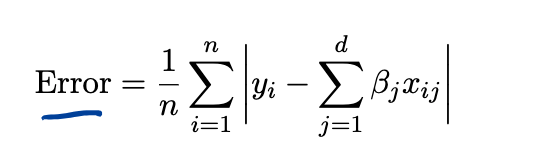

### Our goal is to use Gurobi Optimization tool to build models to minimize the above error term. In this project, I built three models based on different scenario and analyzed the effect them 

In [3]:
from gurobipy import * 
import numpy as np 
import pandas as pd 
import csv

train_set = "/Users/jeremycao/Downloads/AirbnbTrain.csv"
df = pd.read_csv(train_set)
df.head()

,latitude,longitude,Entire home,accommodates,bathrooms,bedrooms,beds,cleaning_fee,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,price
0,34.103701,-118.332241,1,13,2.0,3,2,150,2,1,100,1,350
1,34.099484,-118.331645,1,8,2.0,2,4,150,1,11,96,1,190
2,34.104321,-118.329662,1,4,1.0,0,1,55,1,1,80,0,85
3,34.101028,-118.317848,0,2,1.0,1,1,20,1,8,98,0,75
4,34.098292,-118.324980,1,2,1.0,1,1,20,1,11,96,0,130


In [4]:
x = np.asarray(df) #initial price
x[0,12]

350.0

### MODEL 1:
In Model 1, we formulate the least absolute deviations regression problem as a linear program. 

In [7]:
#Model 1
from gurobipy import * 

mod = Model()
m = mod.addVars(12) # 12 X variables
z = mod.addVars(1700) # 1700 rows of data's predition error term

In [11]:
# constraint 1: for each row of data, the error term should be in the absolute bundary.
for i in range(1700):
    mod.addConstr(z[i] >= x[i,12] - sum(m[j]*x[i,j] for j in range(12))) 
    mod.addConstr(z[i] >= sum(m[j]*x[i,j] for j in range(12)) - x[i,12])

In [12]:
mod.setObjective(sum(z[i] for i in range(1700)) / 1700, GRB.MINIMIZE) # Minimize sum of error

mod.update()
mod.optimize()
opt_val1 = mod.objval

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3400 rows, 1712 columns and 41372 nonzeros
Model fingerprint: 0xa0d487df
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [6e-04, 6e-04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve time: 0.03s
Presolved: 3400 rows, 1712 columns, 41372 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 12
 AA' NZ     : 2.995e+04
 Factor NZ  : 3.260e+04 (roughly 2 MB of memory)
 Factor Ops : 4.141e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.13176381e+03  0.00000000e+00  1.36e+03 0.00e+00  2.72e+01     0s
   1   1.42686270e+03  1.34119445e+00  0.00e+00 

In [17]:
# find the names and coefficients of the variables selected by the optimization model.
for j in range(12):
    print(list(df)[j], m[j].x)

latitude 290.25146635184893
longitude 84.03092762130682
Entire home 36.783237555536715
accommodates 9.936817142125026
bathrooms 31.694331188789405
bedrooms 19.70395711447884
beds 0.0
cleaning_fee 0.3106162814102326
minimum_nights 0.0
number_of_reviews 0.0
review_scores_rating 0.2681158824601206
instant_bookable 5.167454373349855


In [15]:
test_set = "/Users/jeremycao/Downloads/AirbnbTest.csv"
df2 = pd.read_csv(test_set) #Test Set
df2.head() 

,latitude,longitude,Entire home,accommodates,bathrooms,bedrooms,beds,cleaning_fee,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,price
0,34.100604,-118.341787,0,2,1.0,1,1,40,1,261,96,1,100
1,34.100607,-118.350583,1,8,2.0,2,2,100,2,10,98,0,300
2,34.100610,-118.347617,1,2,1.0,1,1,80,2,1,100,1,125
3,34.100611,-118.342180,1,3,1.0,0,2,55,2,54,97,1,169
4,34.100618,-118.342791,1,4,1.0,1,1,70,2,233,92,1,119


In [20]:
# Find Out the prediction error of Model 1
beta1 = []
for j in range(12):
    beta1.append(m[j].x)
x_test = np.asarray(df2)
error1 = (sum(abs(x_test[i,12] - sum(beta1[j]*x_test[i,j] for j in range(12))) for i in range(699)))/699
print("The predict error of Model 1 is", error1)

The predict error of Model 1 is 35.60453503037783


### Model 1 Conclusion

#### In this model, we used gurobi optimization to select variables from train set to build the model to predict Price in the Test Set. The prediction error we got is 35.06

### MODEL 2:
to improve interpretability, I build a model that predicts Airbnb prices using only the three most important variables.

In [22]:
#Model 2
from gurobipy import *

mod = Model()

m = mod.addVars(12) # 12 X variables
z = mod.addVars(1700) # 1700 rows of data's predition error term
p = mod.addVars(12, vtype = GRB.BINARY) # We set a binary variable equal to 1 if that x varibale is included in this model to predict Airbnb Price.
max_bar = 100000

mod.addConstr(sum(p[j] for j in range(12)) == 3) #constraints to select 3 variavles

for j in range(12):
    mod.addConstr(m[j] <= max_bar*p[j])
    
for i in range(1700):
    mod.addConstr(z[i] >= x[i,12] - sum(m[j]*x[i,j] for j in range(12)))  #constraints from model 1
    mod.addConstr(z[i] >= sum(m[j]*x[i,j] for j in range(12)) - x[i,12])

mod.setObjective(sum(z[i] for i in range(1700)) / 1700, GRB.MINIMIZE) # Minimize sum of error

mod.update()
mod.optimize()

opt_val2 = mod.objval

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3413 rows, 1724 columns and 41408 nonzeros
Model fingerprint: 0x68bb8d35
Variable types: 1712 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+05]
  Objective range  [6e-04, 6e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 2e+03]
Found heuristic solution: objective 144.9682353
Presolve removed 828 rows and 414 columns
Presolve time: 0.05s
Presolved: 2585 rows, 1310 columns, 31274 nonzeros
Variable types: 1298 continuous, 12 integer (12 binary)

Root relaxation: objective 3.642625e+01, 1371 iterations, 0.20 seconds (0.35 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   36.42625    0    5  144.96824   36.42625  74.9%     -    0s
H    0     0      

In [24]:
for j in range(12): #find the names and coefficients of the three variables selected by the optimization model.
    print(list(df)[j], m[j].x)

latitude 0.0
longitude 0.0
Entire home 52.0
accommodates 14.0
bathrooms 0.0
bedrooms 32.0
beds 0.0
cleaning_fee 0.0
minimum_nights 0.0
number_of_reviews 0.0
review_scores_rating 0.0
instant_bookable 0.0


***The three variables are Entire home, accommodates, and bedrooms***
***coefficients related to three variables are 52.0, 14.0 and 32.0***

In [28]:
# Find Out the prediction error of Model 2
beta2 = [] 
for j in range(12):
    beta2.append(m[j].x)
x_test2 = np.asarray(df2)
error_2 = (sum(abs(x_test2[i,12] - sum(beta2[j]*x_test2[i,j] for j in range(12))) for i in range(699)))/699
print("The predict error of Model 2 is", error_2)

The predict error of Model 2 is 37.73676680972818


### Model 2 Conclusion

#### In this model, we used gurobi optimization to select three most variables from train set to build the model to predict Price in the Test Set. The prediction error we got is 37.74, which is bigger than Model 1.This makes sense because omitted varibales will decrease the precision of the model(higher prediction error)

### MODEL 3: in this model, I want to build a model that predicts Airbnb listing price using only three variables, where one of the variables is the number of beds.

In [29]:
#Model 3
from gurobipy import * 
mod = Model()

m = mod.addVars(12) # 12 X variables
z = mod.addVars(1700) # 1700 rows of data's predition error term
p = mod.addVars(12, vtype = GRB.BINARY) # We set a binary variable equal to 1 if that x varibale is included in this model to predict Airbnb Price.
max_bar = 100000

mod.addConstr(p[6] == 1) #contraint to make sure '# of beds' is selected
mod.addConstr(sum(p[j] for j in range(12)) == 3) #constraints to select 3 variavles

for j in range(12): 
    mod.addConstr(m[j] <= max_bar*p[j])
    
for i in range(1700): # Constraint from model 1
    mod.addConstr(z[i] >= x[i,12] - sum(m[j]*x[i,j] for j in range(12))) 
    mod.addConstr(z[i] >= sum(m[j]*x[i,j] for j in range(12)) - x[i,12])

mod.setObjective(sum(z[i] for i in range(1700)) / 1700, GRB.MINIMIZE) # Minimize sum of error

mod.update()
mod.optimize()

opt_val3 = mod.objval

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3414 rows, 1724 columns and 41409 nonzeros
Model fingerprint: 0x5944a889
Variable types: 1712 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+05]
  Objective range  [6e-04, 6e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 144.9682353
Presolve removed 830 rows and 415 columns
Presolve time: 0.05s
Presolved: 2584 rows, 1309 columns, 31271 nonzeros
Variable types: 1298 continuous, 11 integer (11 binary)

Root relaxation: objective 3.642625e+01, 1402 iterations, 0.20 seconds (0.35 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   36.42625    0    6  144.96824   36.42625  74.9%     -    0s
H    0     0      

In [30]:
for j in range(12):
    print(list(df)[j], m[j].x)

latitude 0.0
longitude 0.0
Entire home 67.875
accommodates 0.0
bathrooms 0.0
bedrooms 47.375
beds 12.125000000000002
cleaning_fee 0.0
minimum_nights 0.0
number_of_reviews 0.0
review_scores_rating 0.0
instant_bookable 0.0


***The two other variables besides # of beds are 'Entire home' and 'bedrooms'***

***coefficients related to 'entire home' is 67.875 and 'bedrooms' is 12.125***

***Compared to Model 2, The coeficient that is no longer in Model 3 is accommodates. In my opinion, the entire home and bedrooms are the 2 main features to determine the prices. Moreover, the number of beds (beds) and accomodates are kind of similar features to decide how many people can book a Airbnb. But number of beds are always more important to make the decision. Thus, accomodates was the feature to be dropped. This also makes sense***

In [31]:
beta3 = []
for j in range(12):
    beta3.append(m[j].x)
x_test3 = np.asarray(df2)
error_3 = (sum(abs(x_test3[i,12] - sum(beta3[j]*x_test3[i,j] for j in range(12))) for i in range(699)))/699
print("The predict error of Model 3 is", error_3)

The predict error of Model 3 is 38.59960658082976


### Model 2 Conclusion

#### In this model, we used gurobi optimization to select three variables from train set(number of beds must be included) to build the model to predict Price in the Test Set. The prediction error we got is 38.60, which is bigger than Model 2.This makes sense because the variable we omitted in model 3 is one of the most important variables we selected in model 2. It was dropped only because it is less important than 'entire home' and 'bedrooms'. But it is more important than 'number of beds'. 